In [1]:
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

%matplotlib inline
sns.set(color_codes=True)

2022-04-27 22:49:28.838781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
df = pd.read_csv('../../data/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df.columns=['label', 'id', 'Date', 'Query', 'User', 'text']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [3]:
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
df = df.sample(n=100000)

/scratch/ddupertu/.conda/envs/history-digital/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


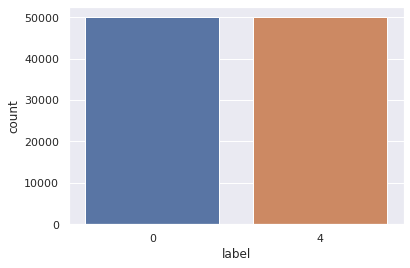

In [5]:
sns.countplot(df['label']);

In [6]:
df['label'] = df.label.replace(4,1)

In [7]:
hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

In [8]:
df['text'] = df.text.apply(process_text)

In [9]:
labels = df.label.values
text = df.text.values

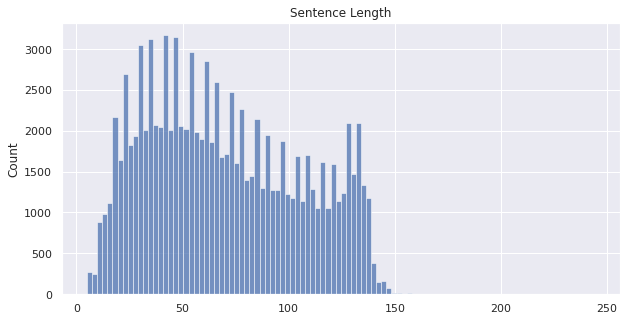

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [11]:
df = df[np.array([len(sent) for sent in df.text]) <= 150]

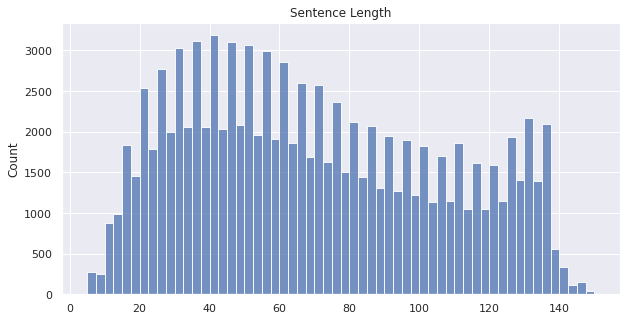

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text])
plt.title('Sentence Length')
plt.show()

In [13]:
#find the maximum length
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

Max length:  150


In [14]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                   df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [15]:
df['data_type'] = ['not_set'] * df.shape[0]

In [16]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby(['label', 'data_type']).count()

text
label data_type       
0     train      42488
      val         7498
1     train      42462
      val         7494

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case = True)

In [18]:
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                padding = 'longest',
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                padding = 'longest',
                                                return_tensors = 'pt')

In [19]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [20]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [21]:
#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [22]:
batch_size = 32

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step


In [23]:
optimizer = AdamW(model.parameters(),
                 lr = 1e-6,
                 eps = 1e-8) #2e-5 > 5e-5
                 
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)


/scratch/ddupertu/.conda/envs/history-digital/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [25]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [26]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'../../report/BERT_ft_epoch{epoch}.model')
    
    tqdm.write(f'\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_ave}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy (weighted): {val_acc}')